## import necessary modules
This module is based on OpenCV, SciPy, Matplotlib. Machine Learing is based on Tensorflow

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import measurements
from scipy.ndimage.morphology import generate_binary_structure
import os
import pandas as pd

## Some exceptions

In [2]:
class EndpointsCheckError(Exception):
	pass
class PersistenceLengthRangeError(Exception):
	pass
class CurvatureRangeError(Exception):
	pass

## Motion Tracking

In [44]:
class mt:
    def __init__(self):
        pass  
    def distance(lo1, lo2, power):
        '''
        Support distance determination.
        --------
        lo1, lo2: two coordinates
        power   : square = 2 , if not = 1
        '''
        if power == 1:
            output = ((lo1[1] - lo2[1]) ** 2 + (lo1[0] - lo2[0]) ** 2) ** 0.5
        elif power == 2:
            output = (lo1[1] - lo2[1]) ** 2 + (lo1[0] - lo2[0]) ** 2
        return output 
    def neighbours(x,y,image):
        '''
        Find the 8 neighbours of 1 coordinate.
        --------
        x, y  : 1 coordinate
        image : image
        '''
        img = image
        x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
        return [ img[x_1][y],img[x_1][y1],img[x][y1],img[x1][y1],        
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]     
    def transitions(neighbours):
        n = neighbours + neighbours[0:1]     
        return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )   
    def zhangSuen(image):
        '''
        Thin the image to remove noisy inside.
        '''
        Image_Thinned = image.copy()  # Making copy to protect original image
        changing1 = changing2 = 1
        while changing1 or changing2:   # Iterates until no further changes occur in the image
            # Step 1
            changing1 = []
            rows, columns = Image_Thinned.shape
            for x in range(1, rows - 1):
                for y in range(1, columns - 1):
                    P2,P3,P4,P5,P6,P7,P8,P9 = n = mt.neighbours(x, y, Image_Thinned)
                    if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                        2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                        mt.transitions(n) == 1 and    # Condition 2: S(P1)=1  
                        P2 * P4 * P6 == 0  and    # Condition 3   
                        P4 * P6 * P8 == 0):         # Condition 4
                        changing1.append((x,y))
            for x, y in changing1: 
                Image_Thinned[x][y] = 0
            # Step 2
            changing2 = []
            for x in range(1, rows - 1):
                for y in range(1, columns - 1):
                    P2,P3,P4,P5,P6,P7,P8,P9 = n = mt.neighbours(x, y, Image_Thinned)
                    if (Image_Thinned[x][y] == 1   and        # Condition 0
                        2 <= sum(n) <= 6  and       # Condition 1
                        mt.transitions(n) == 1 and      # Condition 2
                        P2 * P4 * P8 == 0 and       # Condition 3
                        P2 * P6 * P8 == 0):            # Condition 4
                        changing2.append((x,y))    
            for x, y in changing2: 
                Image_Thinned[x][y] = 0
        return Image_Thinned  
    def largestConnect(thresh): 
        '''
        Find the biggest fiber in binary image. Fiber should be 1 and
        the others should be 0.
        Input an shape_dim=2 array, output is an shape_dim=2 array as well.
        '''
        threshCopy = thresh.copy()
        s = generate_binary_structure(2,2)
        label, number = measurements.label(thresh, structure=s)
        area = measurements.sum(thresh, label, index = range(label.max() + 1))
        areaImg = area[label]
        maxFiber = areaImg.max()
        for y in range(len(thresh)):
            for x in range(len(thresh[0])):
                if areaImg[y][x] == maxFiber:
                    threshCopy[y][x] = 1
                else:
                    threshCopy[y][x] = 0
        return threshCopy   
    def endPoint(thresh, level): 
        '''
        Find the endpoints of one fiber.
        --------
        thresh : a binary image with only one connective domain
        level  : the size of maxium kernel
        '''
        threshCopy = thresh.copy()
        endpoints = []
        for y in range(len(threshCopy)):
            for x in range(len(threshCopy[0])):
                if threshCopy[y][x] == 1:
                    endpoints.append([y,x])
        filterRank = 0
        while filterRank < level:
            filterRank += 1
            endpointsNew = []
            for [y,x] in endpoints:
                pendMatrix = threshCopy[y-filterRank:y+filterRank+1,x-filterRank:x+filterRank+1]
                sumMatrix = sum(map(sum, pendMatrix))
                connCheck = (filterRank+1)**2
                if sumMatrix > connCheck:
                    pass
                else:
                    endpointsNew.append([y,x])
            endpoints = endpointsNew
        if len(endpoints) > 2:
            start = endpoints[0]
            distanceStore = []
            for point in endpoints:
                distanceStore.append(mt.distance(point, start, 2))
            end = endpoints[endpoints.index(max(endpoints))]
            endpoints = [start, end]
        return endpoints    
    def step(lo, roi, path, key):
        '''
        Step and direction for maze.
        If one step is available, it returns new location. Otherwise the direction.
        --------
        lo  : location now
        map : input binary image
        path: list of correct locations
        key : direction now
        '''
        if key == 0 or key == 4:
            if (roi[lo[0] + 1, lo[1]] == 1) and ([lo[0] + 1, lo[1]] not in path):
                lo = [lo[0] + 1,lo[1]]
                return(lo)
            else:
                return(1)
        elif key == 1:
            if (roi[lo[0], lo[1] + 1] == 1) and ([lo[0], lo[1] + 1] not in path):
                lo = [lo[0], lo[1] + 1]
                return(lo)
            else:
                return(2)
        elif key == 2:
            if (roi[lo[0] - 1, lo[1]] == 1):
                lo = [lo[0] - 1,lo[1]]
                return(lo)
            else:
                return(3)
        elif key == -1 or key == 3:
            if (roi[lo[0], lo[1] - 1] == 1):
                lo = [lo[0], lo[1] - 1]
                return(lo)
            else:
                return(0)
        else:
            print("direction error 4")            
    def trace(expoint, roi):
        '''
        Fine a path for fiber.
        --------
        expoint: the two endpoints
        roi    : the fiber map, which is a binary image
        '''
        if len(expoint) == 2:
            lo = expoint[0]
            path = [lo]
            i = 0
            while lo != expoint[1]:
                if i < 0:
                    i += 4
                else:
                    pass
                ts_1 = mt.step(lo, roi, path, i-1)
                ts = mt.step(lo, roi, path, i)
                ts1 = mt.step(lo, roi, path, i+1)
                if type(ts_1) == list:
                    lo = ts_1
                    i = i - 1
                elif type(ts) == list:
                    lo = ts
                elif type(ts1) == list:
                    lo == ts1
                    i = ts
                else:
                    pass
                if lo != path[-1]:
                    path.append(lo)
                else:
                    pass
            return path
        else:
            raise EndpointsCheckError
    def imageProcess(image): 
        '''
        Here to proccess the single image.
        '''
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray, 180, cv2.ADAPTIVE_THRESH_MEAN_C, \
        cv2.THRESH_BINARY_INV, 5, 2)
        roi = mt.largestConnect(thresh)
        thin = mt.zhangSuen(roi)
        dilate = cv2.dilate(thin, None, iterations = 1)
        return dilate
    def imageFileProcess(filepath,start,end,interval):
        '''
        Analysis all the images in a file.
        '''
        pngs = os.listdir(filepath)
        pngs.sort(key = lambda x:int(x[:-4]))
        fiberStatCalculate = []
        fiberDataForEach = []
        for pngNumber in range(0,len(pngs),interval):
            image = cv2.imread(filepath+'/'+pngs[pngNumber - 1])
            thresh = mt.imageProcess(image)
            roi = thresh.copy()
            try:
                endPoints = mt.endPoint(roi, 2)
                if len(endPoints) == 2:
                    path = mt.trace(endPoints, roi)
                    pixLen = mc.pixLen(path)
                    msrg = mc.msrg(path)
                    mse2e = mc.mse2e(path)
                    e2e = mc.e2e(path)
                    persLen = mc.persLen(path, 10)
                    curvatureMean, curvatureStd = mc.curvature(path, 5)
                    second = (pngNumber+start-1)/30
                    fiberDataForEach = [second, pixLen, msrg, mse2e,e2e, persLen, curvatureMean, curvatureStd]
                    print(pngNumber,"is",fiberDataForEach)
                    fiberStatCalculate.append(fiberDataForEach)
            except(PersistenceLengthRangeError):
                print('{}.png is PersistenceLengthRangeError'.format(pngNumber))
            except(CurvatureRangeError):
                print('{}.png is CurvatureRangeError'.format(pngNumber))
            except(IndexError):
                print('Please check the shape of {}.png'.format(pngNumber))
        print(pngNumber)
        df = pd.DataFrame(fiberStatCalculate)
        df.columns = ['second','length','msrg','mse2e','e2e','persistence','curvature','std']
        #dfnormal = df.drop(columns=['std'])
        return df
    def imageFilePOI(filepath):
        '''
        Analysis POI in a file.
        '''
        pngs = os.listdir(filePath)
        pngs.sort(key = lambda x:int(x[:-4]))
        fiberStatCalculate = []
        for pngNumber in range(1, len(pngs)+1, 30):
            image = cv2.imread(filePath+'/'+pngs[pngNumber - 1])
            thresh = mt.imageProcess(image)
            roi = thresh.copy()
            try:
                endPoints = mt.endPoint(roi, 2)
                if len(endPoints) == 2:
                    path = mt.trace(endPoints, roi)
                    
                    curvature = mc.curvatureiloc(path, 10, rate1, rate2)
                    second = (pngNumber-1)/30
                    print(pngNumber,"is",curvature)
                    fiberStatCalculate.append(curvature)
            except(PersistenceLengthRangeError):
                print('{}.png is PersistenceLengthRangeError'.format(pngNumber))
            except(CurvatureRangeError):
                print('{}.png is CurvatureRangeError'.format(pngNumber))
            except(IndexError):
                print('Please check the shape of {}.png'.format(pngNumber))
            print(pngNumber)
        df = pd.DataFrame(fiberStatCalculate)
        return df
    def correct(df):
        '''
        Remove the wrong reading result by comparing length.
        --------
        df : the analysis result of imageFileProccess
        '''
        meanLength = df['length'].mean()
        dfCorr = df[df['length']>meanLength * 0.9]
        dfCorr = dfCorr[dfCorr['length']<meanLength * 1.1]
        return dfCorr

## Morphology Calculation

In [16]:
class mc:
    '''
    In Morphology Calculation, the input must be coordinates sequence
    '''
    def __init__(self):
        pass
    def pixLen(path): 
        '''
        Calculate the length by counting pixels.
        --------
        path: list of coordinates sequence
        '''
        output = len(path)
        return output 
    def msrg(path): 
        '''
        Calculate the mean square radius of gyration.
        '''
        pathMatrix = np.array(path)
        fiberCenter = pathMatrix.mean(axis = 0)
        output = 0
        for pix in path:
            output += mt.distance(pix, fiberCenter, 2)
        output = output / len(path)
        return output 
    def mse2e(path): 
        '''
        Calculate the square of end to end distance.
        '''
        output = mt.distance(path[0], path[-1], 2)
        return output
    def e2e(path): 
        '''
        Calculate the end to end distance.
        '''
        output = mt.distance(path[0], path[-1], 1)
        return output
    def persLen(path, s): 
        '''
        Calculate the persistence length.
        The projection on the first chain segment.
        --------
        path: list of coordinates sequence
        s   : length of the custom chain segment
        '''
        if len(path) > s:
            lenCluster = []
            start = [path[s][0] - path[0][0], path[s][1] - path[0][1]]
            projectStart = (start[0] ** 2 + start[1] ** 2) ** 0.5
            full  = [path[-1][0] - path[0][0], path[-1][1] - path[0][1]]
            projection = (start[0] * full[0] + start[1] * full[1]) / projectStart
            return projection
        else:
            # It means the path is too short for slice.
            raise PersistenceLengthRangeError
    def curvature(path, s):
        '''
        Calculate the curvature list.
        --------
        path: list of coordinates sequence
        s   : length of the custom chain segment
        '''
        if len(path) > 2*s:
            curvature = []
            for i in range(s, len(path) - s):
                a = path[i-s]
                b = path[i]
                c = path[i+s]
                x = mt.distance(a, b, 1)
                y = mt.distance(a, c, 1)
                z = mt.distance(b, c, 1)
                try:
                    r = x*y*z/(((x+y-z)*(x-y+z)*(y+z-x)*(x+y+z))**0.5)
                    cur = 1 / r
                except ZeroDivisionError:
                    cur = 0
                finally:
                    curvature.append(cur)
            return(np.mean(curvature), np.std(curvature))
            #return curvature
        else:
            raise CurvatureRangeError
    def curvatureiloc(path, s, rate1, rate2):
        '''
        Calculate the POI.
        --------
        path: list of coordinates sequence
        s   : length of the custom chain segment
        rate1: the start of POI
        rate2: the end of POI
        '''
        index1 = len(path) * rate1
        index1 = round(index1)
        index2 = len(path) * rate2
        index2 = round(index2)
        if len(path) > 2*s:
            curvature = []
            for i in range(s, len(path) - s):
                a = path[i-s]
                b = path[i]
                c = path[i+s]
                x = mt.distance(a, b, 1)
                y = mt.distance(a, c, 1)
                z = mt.distance(b, c, 1)
                try:
                    r = x*y*z/(((x+y-z)*(x-y+z)*(y+z-x)*(x+y+z))**0.5)
                    cur = 1 / r
                except ZeroDivisionError:
                    cur = 0
                finally:
                    curvature.append(cur)
            curSpare = curvature[index1:index2]
            return np.mean(curSpare)
        else:
            raise CurvatureRangeError
    def simplify(path, number):
        '''
        Sparse the path.
        --------
        path: list of coordinates sequence
        number: the number of points you want to use
        '''
        pixIndex = list(np.linspace(0,len(path)-1,number))
        simplified = []
        for i in pixIndex:
            simplified.append(path[int(i)])
        return simplified      

## Motion Prediction

In [17]:
class mp:
    '''
    Motion Prediction
    '''
    def __init__(self):
        pass
    def calLen(path):
        long = 0
        for i in range(len(path)-1):
            long += mc.distance(path[i],path[i+1],1)
        return long
    def msrg(path):
        pathArray = np.array(path)
        fiberCenter = pathArray.mean(axis = 0)
        output = 0
        for point in path:
            output += mc.distance(point,fiberCenter,2)
        output = output / len(path)
        return output
    def mse2e(path):
        output = mc.distance(path[0],path[-1],2)
        return output
    def e2e(path):
        output = mc.distance(path[0],path[-1],1)
        return output
    def curvature(path,outype):
        curvature = []
        for i in range(1,len(path)-1):
            a = path[i-1]
            b = path[i]
            c = path[i+1]
            x = mc.distance(a,b,1)
            y = mc.distance(a,c,1)
            z = mc.distance(b,c,1)
            try:
                r = x*y*z/(((x+y-z)*(x-y+z)*(y+z-x)*(x+y+z))**0.5)
                cur = 1 / r
            except ZeroDivisionError:
                cur = 0
            finally:
                curvature.append(cur)
        if outype == 'list':
            return curvature
        elif outype == 'mean':
            return (np.mean(curvature),np.std(curvature))
    def persLen(path):
        lenList = []
        start = [path[1][0]-path[0][0],path[1][1]-path[0][1]]
        projectStart = (start[0]**2 +start[1]**2)**0.5
        for i in range(0,len(path)-1):
            other = [path[i+1][0]-path[i][0],path[i+1][1]-path[i][1]]
            projection = (start[0]*other[0]+start[1]*other[1])
            lenList.append(abs(projection))
        output = np.mean(lenList)/(len(path)-1)
        return output
    def lineplot(path,color,linewidth):
        '''
        Plot the motion and show
        --------
        color : the color of fiber
        linewidth : the width of motion predicted,which is recommend to be 1
        '''
        pathB = path[1:]
        pathA = path[:-1]
        for i in range(len(pathA)):
            plt.plot([pathA[i][1],pathB[i][1]],[pathA[i][0],pathB[i][0]],color=color,linewidth=linewidth)
        plt.grid('off')
        plt.axis('equal')
        plt.axis('off')
        plt.gca().invert_yaxis()
    def continuous_1(model,sequence,order):
        '''
        If the model is a multi-output one, you need this to choose the real output.
        --------
        model : the machine learning model
        sequence : the coordinates sequence
        order : the iteration number
        '''
        time = len(sequence) - 1
        assert(order <= time)
        for i in range(order):
            if i == 0:
                f = np.expand_dims(sequence[0], axis=0)
            else:
                f = fout.copy()
            fout = model.predict(f)
        fout = np.squeeze(fout,axis=0)
        return fout
    def continuous(model,sequence,order):
        '''
        If the model is a sequential one.
        --------
        model : the machine learning model
        sequence : the coordinates sequence
        order : the iteration number
        '''
        time = len(sequence) - 1
        assert(order <= time)
        for i in range(order):
            if i == 0:
                f = np.expand_dims(sequence[0], axis=0)
            else:
                f = fout.copy()
            fout = model.predict(f)
        fout = fout
        fout = np.squeeze(fout,axis=0)
        return fout
    def mse(pathR,pathP):
        '''
        Calculate the mse of two motion.
        Sometimes it is meanless.
        --------
        pathR : the raw path
        pathP : the path from prediction
        '''
        pathr = np.reshape(pathR,(20,))
        pathp = np.reshape(pathP,(20,))
        difference = pathr - pathp
        square = difference ** 2
        mse = np.mean(square)
        return mse
    def simulate(model,val,times):
        '''
        Calculate the parameters while predicting
        --------
        model : the trained model
        val   : validation data
        times : iterations
        '''
        precList=[]
        for i in range(0,times):
            raw = val[i,:,:]
            if i != 0:
                prec = continuous(model,val[0:times,:,:],i)
            else:
                prec = raw
            calLen = mp.calLen(prec)
            msrg = mp.msrg(prec)
            mse2e = mp.mse2e(prec)
            curvature = mp.curvature(prec,outype='mean')[0]
            persLen = mp.persLen(prec)
            precList.append([calLen,msrg, mse2e, persLen, curvature])
        out = pd.DataFrame(precList)
        out.columns = ['length','msrg','mse2e','persistence','curvature']
        return out

In [18]:
%matplotlib inline

# An example

#### read the images in the file and calculate the parameters at the same time

In [85]:
# Use your imagefile here
filepath = r"D:/camelCircle/9Wet"
df = mt.imageFileProcess(filepath,28080,32340,3)

0 is [935.9666666666667, 286, 3401.04705609076, 33629, 183.38211472223784, 40.30508652763321, 0.04432280032523426, 0.05140842216460208]
3 is [936.0666666666667, 288, 1758.9012104552462, 8945, 94.57801012920498, -69.60772438542756, 0.05393923918436181, 0.04986542606434978]
6 is [936.1666666666666, 288, 1763.1232397762356, 8945, 94.57801012920498, -69.60772438542756, 0.05142122793871345, 0.05023077140699549]
9 is [936.2666666666667, 287, 1768.7974359285652, 9050, 95.13148795220224, -70.57786688557289, 0.05232086400700967, 0.04807523194161536]
12 is [936.3666666666667, 288, 1779.8008294753092, 9209, 95.96353474106714, -63.78103166302658, 0.05365990667519432, 0.049996629745787]
15 is [936.4666666666667, 290, 1795.2970392390012, 9805, 99.02019995940222, -41.7193000900063, 0.05334553291767526, 0.048882024068901256]
18 is [936.5666666666667, 289, 1802.7230995797465, 9586, 97.9081201943945, -65.90235200658623, 0.050976899771420725, 0.04825984404228155]
21 is [936.6666666666666, 289, 1807.26157

In [86]:
df['persistence']=abs(df['persistence'])

#### Remove the wrong results by comparing length.
#### Save the output "df" as excel.

In [91]:
df.to_excel('9Wet.xlsx',encoding='utf-8',index=False)
meanLength = df['length'].mean()
dfCorr = df[df['length']>meanLength * 0.9]
dfCorr = dfCorr[dfCorr['length']<meanLength * 1.1]
dfCorr.to_excel('9Wetc.xlsx',encoding='utf-8',index=False)

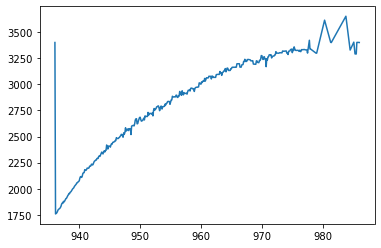

In [88]:
plt.plot(dfCorr['second'],dfCorr['msrg'])